## Breast Cancer Proteomes
### Dividing cancer patients into separate sub-classes

The data was acquired to assess how the mutations in the DNA are affecting the protein expression landscape in breast cancer. Genes in our DNA are first transcribed into RNA molecules which then are translated into proteins. Changing the information content of DNA has impact on the behavior of the proteome, which is the main functional unit of cells, taking care of cell division, DNA repair, enzymatic reactions and signaling etc. They original study performed K-means clustering on the protein data to divide the breast cancer patients into sub-types, each having unique protein expression signature. They found that the best clustering was achieved using 3 clusters (original PAM50 gene set yields four different subtypes using RNA data). I'll run various dimensionality reduction techniques and clustering methods and compare my results with the original study.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import datasets, metrics
from sklearn.manifold import TSNE
import umap

In [2]:
expression = pd.read_csv(r'C:\Users\mike1\Documents\Thinkful\77_cancer_proteomes_CPTAC_itraq.csv', header = 0, index_col = 0)
clinical = pd.read_csv(r'C:\Users\mike1\Documents\Thinkful\clinical_data_breast_cancer.csv', header = 0, index_col = 0)

In [3]:
## Drop unused information columns and healthy patients
expression.drop(['gene_symbol','gene_name', '263d3f-I.CPTAC', 'blcdb9-I.CPTAC', 'c4155b-C.CPTAC'],axis=1,inplace=True)
  
## Change the protein data sample names to a format matching the clinical data set
expression.rename(columns=lambda x: "TCGA-%s" % (re.split('[_|-|.]',x)[0]) if bool(re.search("TCGA",x)) is True else x,inplace=True)
 
## Transpose data for the clustering algorithm since we want to divide patient samples, not proteins
expression = expression.transpose()
 
## Drop clinical entries for samples not in our protein data set
clinical = clinical.loc[[x for x in clinical.index.tolist() if x in expression.index],:]
 
## Add clinical meta data to our protein data set, note: all numerical features for analysis start with NP_ or XP_
proteomes = expression.merge(clinical,left_index=True,right_index=True)

## Numerical data for the algorithm, NP_xx/XP_xx are protein identifiers from RefSeq database
proteomes = proteomes.loc[:,[x for x in proteomes.columns if bool(re.search("NP_|XP_",x)) == True]]

In [4]:
## NaNs indicate that no protein was found in the screening so I will replace those with zeros. 
proteomes.fillna(0, inplace = True)
proteomes

,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,...,NP_001193600,NP_061134,NP_932347,NP_003593,NP_997203,NP_001191293,NP_775791,NP_004065,NP_068752,NP_219494
TCGA-A2-A0CM,0.683404,0.694424,0.698098,0.687077,0.687077,0.698098,0.698098,0.698098,-2.652150,-0.984373,...,0.000000,0.000000,1.153614,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TCGA-A2-A0D2,0.107491,0.104164,0.107491,0.097512,0.104164,0.104164,0.104164,0.104164,-0.880454,-1.512473,...,0.919136,-1.648856,0.832649,0.000000,-8.324969,-4.679219,0.000000,-1.106650,0.000000,-6.941181
TCGA-A2-A0EQ,-0.912670,-0.927979,-0.927979,-0.931806,-0.927979,-0.927979,-0.927979,-0.927979,-3.071151,-2.278943,...,-0.801685,0.000000,0.000000,3.802310,-6.373934,-1.123160,0.000000,0.000000,0.000000,0.000000
TCGA-A2-A0EV,0.452986,0.472590,0.472590,0.458587,0.472590,0.472590,0.472590,0.472590,-0.742871,1.811277,...,-4.966177,-1.471027,0.000000,-0.474013,-12.278546,-10.337729,-0.653251,0.000000,0.000000,0.000000
TCGA-A2-A0EX,1.185108,1.192612,1.188860,1.185108,1.200116,1.188860,1.188860,1.192612,1.046289,2.138081,...,1.451490,-2.018981,0.877456,0.000000,0.000000,-6.101005,0.000000,-1.726336,0.000000,0.000000
TCGA-A2-A0EY,1.174881,1.183209,1.183209,1.174881,1.179045,1.183209,1.183209,1.183209,4.955702,0.825113,...,-0.861266,-0.507334,0.000000,0.000000,4.597606,6.179888,0.000000,0.000000,0.000000,0.000000
TCGA-A2-A0SW,-0.487772,-0.487772,-0.487772,-0.487772,-0.503853,-0.487772,-0.487772,-0.487772,-1.626289,0.731148,...,0.596070,0.969143,0.000000,-1.053815,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TCGA-A2-A0SX,-0.398560,-0.392601,-0.392601,-0.392601,-0.395581,-0.392601,-0.392601,-0.392601,-2.504862,0.694810,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TCGA-A2-A0T3,0.583713,0.580623,0.580623,0.586803,0.586803,0.586803,0.586803,0.586803,0.052212,1.501479,...,-4.060739,-1.650444,-0.578172,2.017529,0.000000,-12.265010,0.000000,-1.264179,-1.100403,-5.590348
TCGA-A2-A0T6,0.793976,0.818182,0.814724,0.800892,0.818182,0.811266,0.811266,0.811266,1.381834,1.565108,...,-4.195908,-2.415042,-0.620344,0.002095,0.000000,-13.120988,0.000000,0.000000,1.181271,0.000000


We now have a a cleaned up data frame with each row representing a different patient and each column representing a different protein and its expression level. Now we can perform unsupervised learning to cluster the patients together based off their protein expression levels. But first we'll perform dimensionality reduction techniques on the data.  

### Apply dimensionality reduction techniques to visualize the observations.

In [5]:
X = proteomes
## Don't have a target variable

# Normalize
X_std = StandardScaler().fit_transform(X)

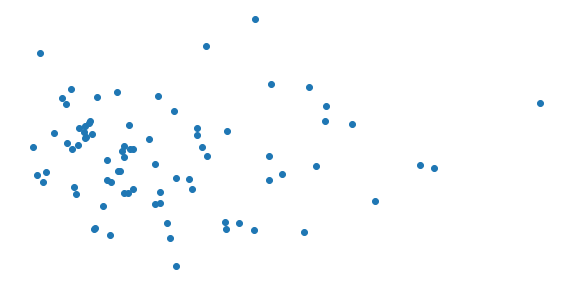

In [6]:
# visualize pca
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_std)

plt.figure(figsize=(10,5))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 80 samples in 0.109s...
[t-SNE] Computed neighbors for 80 samples in 0.158s...
[t-SNE] Computed conditional probabilities for sample 80 / 80
[t-SNE] Mean sigma: 33.576667
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.093788
[t-SNE] KL divergence after 300 iterations: 2.755061


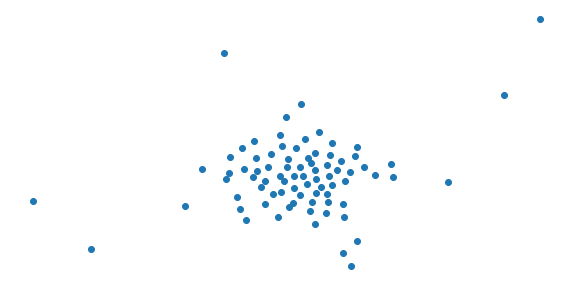

In [7]:
# visualize t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

plt.figure(figsize=(10,5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

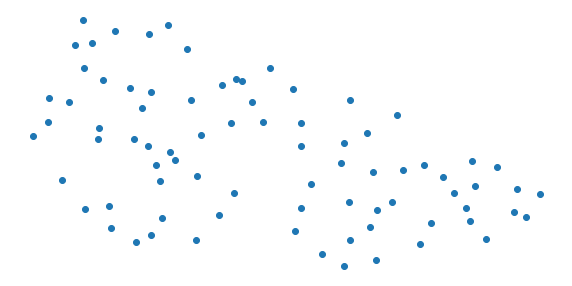

In [8]:
# visualize UMAP
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.5,
                      metric='correlation').fit_transform(X_std)

plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

Applying the dimensionality reductions using PCA, t-SNE, and UMAP they all did a really good job at separating out the patients based off their protein expression levels. UMAP and t-SNE seemed to have separated the patients more clearly than PCA and since we were only dealing with 80 rows, all these methods were very fast so speed was not an issue. It's pretty interesting that there is enough of a difference in the expression levels for all patients that we can visualize each patient as being rather distinguishable from the next. Next, we'll look at three different clustering methods and see if we can group patients together based off their proteomes.  

### Apply clustering techniques to group together similar observations.

#### K-means clustering

In [22]:
labels = KMeans(n_clusters=2, random_state = 123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

0.1012283420786038


In [23]:
labels = KMeans(n_clusters=3, random_state = 123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

0.03952720798708963


In [24]:
labels = KMeans(n_clusters=4, random_state = 123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

0.03713302489512278


In [25]:
labels = KMeans(n_clusters=5, random_state = 123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

0.030709150372061938


In [26]:
labels = KMeans(n_clusters=10, random_state = 123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

0.03535820068079128


The best silhouette score for k-means clustering was at 2 clusters with a score of 0.101. As we increase the number of clusters the score seems to drop, but not significantly after 3 clusters. 

#### Hierarchical clustering

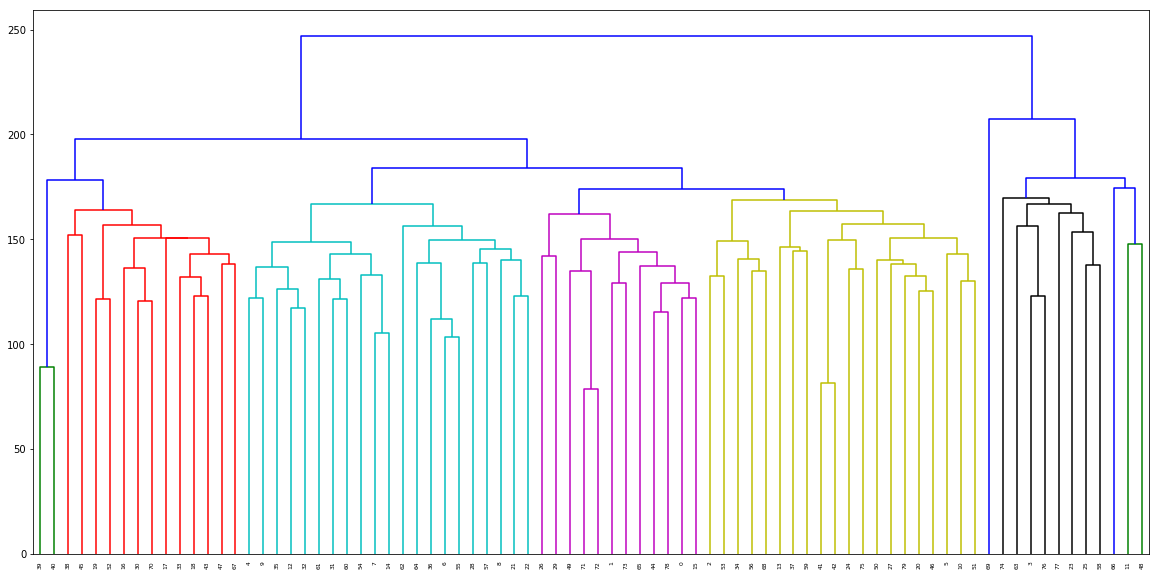

In [10]:
plt.figure(figsize=(20,10))
dendrogram(linkage(X_std, method='complete'))
plt.show()

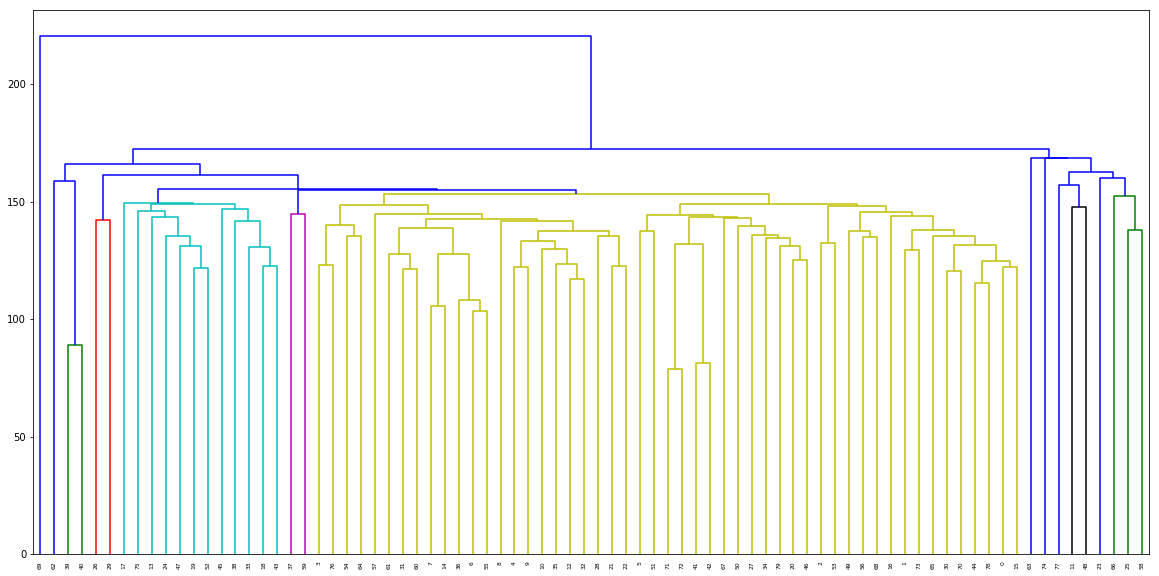

In [11]:
# Average linkage method
plt.figure(figsize=(20,10))
dendrogram(linkage(X_std, method='average'))
plt.show()

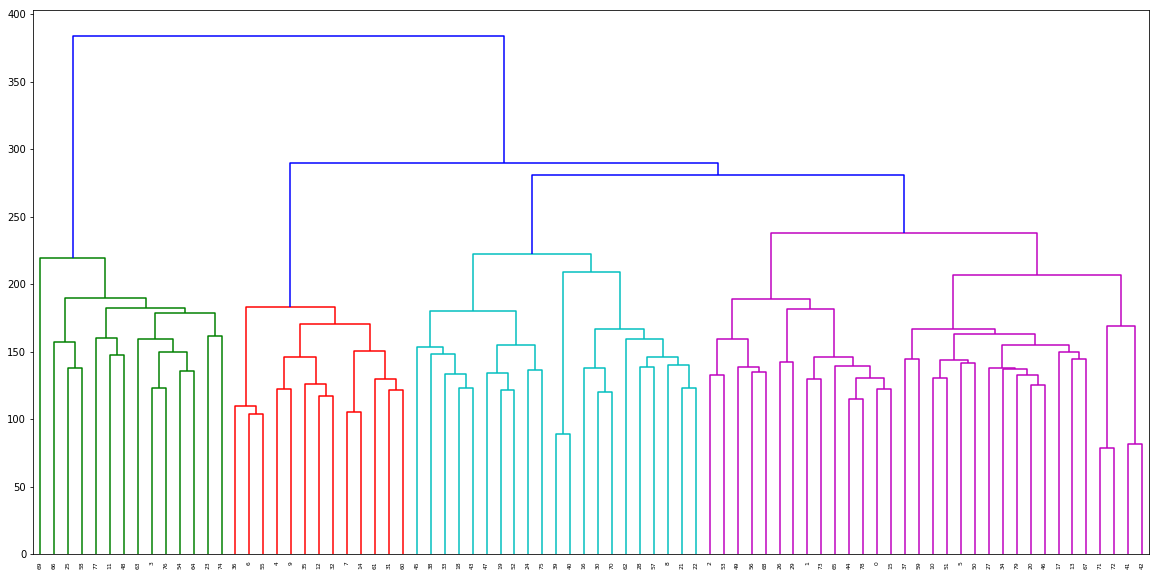

In [12]:
# Ward linkage method
plt.figure(figsize=(20,10))
dendrogram(linkage(X_std, method='ward'))
plt.show()

Looking at the dendrograms, the ward method seemed to do the best job of grouping the patients together and there seems to be four good clusters there. 

In [29]:
# Defining the agglomerative clustering -- complete
agg_cluster2 = AgglomerativeClustering(linkage='complete',
                                      affinity = 'cosine',
                                      n_clusters=2)
agg_cluster3 = AgglomerativeClustering(linkage='complete',
                                      affinity = 'cosine',
                                      n_clusters=3)
agg_cluster4 = AgglomerativeClustering(linkage='complete',
                                      affinity = 'cosine',
                                      n_clusters=4)
agg_cluster10 = AgglomerativeClustering(linkage='complete',
                                      affinity = 'cosine',
                                       n_clusters=10)
# Fit model
clusters2 = agg_cluster2.fit_predict(X_std)
print("The silhoutte score of the Agglomerative Clustering solution with complete linkage, n=2: {}"
      .format(metrics.silhouette_score(X_std, clusters2, metric='euclidean')))
clusters3 = agg_cluster3.fit_predict(X_std)
print("The silhoutte score of the Agglomerative Clustering solution with complete linkage, n=3: {}"
      .format(metrics.silhouette_score(X_std, clusters3, metric='euclidean')))
clusters4 = agg_cluster4.fit_predict(X_std)
print("The silhoutte score of the Agglomerative Clustering solution with complete linkage, n=4: {}"
      .format(metrics.silhouette_score(X_std, clusters4, metric='euclidean')))
clusters10 = agg_cluster10.fit_predict(X_std)
print("The silhoutte score of the Agglomerative Clustering solution with complete linkage, n=10: {}"
      .format(metrics.silhouette_score(X_std, clusters10, metric='euclidean')))

The silhoutte score of the Agglomerative Clustering solution with complete linkage, n=2: 0.04676462229834932
The silhoutte score of the Agglomerative Clustering solution with complete linkage, n=3: 0.0050353060430472505
The silhoutte score of the Agglomerative Clustering solution with complete linkage, n=4: 0.0014533883710115534
The silhoutte score of the Agglomerative Clustering solution with complete linkage, n=10: 0.024794329145641926


In [30]:
# Defining the agglomerative clustering -- average
agg_cluster2 = AgglomerativeClustering(linkage='average',
                                      affinity = 'cosine',
                                      n_clusters=2)
agg_cluster3 = AgglomerativeClustering(linkage='average',
                                      affinity = 'cosine',
                                      n_clusters=3)
agg_cluster4 = AgglomerativeClustering(linkage='average',
                                      affinity = 'cosine',
                                      n_clusters=4)
agg_cluster10 = AgglomerativeClustering(linkage='average',
                                      affinity = 'cosine',
                                       n_clusters=10)
# Fit model
clusters2 = agg_cluster2.fit_predict(X_std)
print("The silhoutte score of the Agglomerative Clustering solution with complete linkage, n=2: {}"
      .format(metrics.silhouette_score(X_std, clusters2, metric='euclidean')))
clusters3 = agg_cluster3.fit_predict(X_std)
print("The silhoutte score of the Agglomerative Clustering solution with complete linkage, n=3: {}"
      .format(metrics.silhouette_score(X_std, clusters3, metric='euclidean')))
clusters4 = agg_cluster4.fit_predict(X_std)
print("The silhoutte score of the Agglomerative Clustering solution with complete linkage, n=4: {}"
      .format(metrics.silhouette_score(X_std, clusters4, metric='euclidean')))
clusters10 = agg_cluster10.fit_predict(X_std)
print("The silhoutte score of the Agglomerative Clustering solution with complete linkage, n=10: {}"
      .format(metrics.silhouette_score(X_std, clusters10, metric='euclidean')))

The silhoutte score of the Agglomerative Clustering solution with complete linkage, n=2: 0.06016452642670127
The silhoutte score of the Agglomerative Clustering solution with complete linkage, n=3: 0.03650987868927834
The silhoutte score of the Agglomerative Clustering solution with complete linkage, n=4: 0.035681103504028526
The silhoutte score of the Agglomerative Clustering solution with complete linkage, n=10: 0.027592305783544824


In [32]:
# Defining the agglomerative clustering -- ward
agg_cluster2 = AgglomerativeClustering(linkage='ward',
                                      affinity = 'euclidean',
                                      n_clusters=2)
agg_cluster3 = AgglomerativeClustering(linkage='ward',
                                      affinity = 'euclidean',
                                      n_clusters=3)
agg_cluster4 = AgglomerativeClustering(linkage='ward',
                                      affinity = 'euclidean',
                                      n_clusters=4)
agg_cluster10 = AgglomerativeClustering(linkage='ward',
                                      affinity = 'euclidean',
                                       n_clusters=10)
# Fit model
clusters2 = agg_cluster2.fit_predict(X_std)
print("The silhoutte score of the Agglomerative Clustering solution with complete linkage, n=2: {}"
      .format(metrics.silhouette_score(X_std, clusters2, metric='euclidean')))
clusters3 = agg_cluster3.fit_predict(X_std)
print("The silhoutte score of the Agglomerative Clustering solution with complete linkage, n=3: {}"
      .format(metrics.silhouette_score(X_std, clusters3, metric='euclidean')))
clusters4 = agg_cluster4.fit_predict(X_std)
print("The silhoutte score of the Agglomerative Clustering solution with complete linkage, n=4: {}"
      .format(metrics.silhouette_score(X_std, clusters4, metric='euclidean')))
clusters10 = agg_cluster10.fit_predict(X_std)
print("The silhoutte score of the Agglomerative Clustering solution with complete linkage, n=10: {}"
      .format(metrics.silhouette_score(X_std, clusters10, metric='euclidean')))

The silhoutte score of the Agglomerative Clustering solution with complete linkage, n=2: 0.10741689230299238
The silhoutte score of the Agglomerative Clustering solution with complete linkage, n=3: 0.029302414977758935
The silhoutte score of the Agglomerative Clustering solution with complete linkage, n=4: 0.03569987700618661
The silhoutte score of the Agglomerative Clustering solution with complete linkage, n=10: 0.05079092703146838


Best silhouette score was for the ward method at two clusters. Just a little higher than the k-means score with 2 clusters, 0.107 versus 0.101. 

#### GMM clustering

In [34]:
# diag covariance type
gmm_cluster2 = GaussianMixture(n_components=2, covariance_type = 'diag', random_state=123)
clusters2 = gmm_cluster2.fit_predict(X_std)

gmm_cluster3 = GaussianMixture(n_components=3, covariance_type = 'diag', random_state=123)
clusters3 = gmm_cluster3.fit_predict(X_std)

gmm_cluster4 = GaussianMixture(n_components=4, covariance_type = 'diag', random_state=123)
clusters4 = gmm_cluster4.fit_predict(X_std)

gmm_cluster10 = GaussianMixture(n_components=10, covariance_type = 'diag', random_state=123)
clusters10 = gmm_cluster10.fit_predict(X_std)

print("The silhoutte score of the GMM solution, n=2: {}"
      .format(metrics.silhouette_score(X_std, clusters2, metric='euclidean')))
print("The silhoutte score of the GMM solution, n=3: {}"
      .format(metrics.silhouette_score(X_std, clusters3, metric='euclidean')))
print("The silhoutte score of the GMM solution, n=4: {}"
      .format(metrics.silhouette_score(X_std, clusters4, metric='euclidean')))
print("The silhoutte score of the GMM solution, n=10: {}"
      .format(metrics.silhouette_score(X_std, clusters10, metric='euclidean')))

The silhoutte score of the GMM solution, n=2: 0.10883382039313987
The silhoutte score of the GMM solution, n=3: 0.06012530358754177
The silhoutte score of the GMM solution, n=4: 0.04087478423993213
The silhoutte score of the GMM solution, n=10: 0.026204243455782365


In [35]:
# spherical covariance type
gmm_cluster2 = GaussianMixture(n_components=2, covariance_type = 'spherical', random_state=123)
clusters2 = gmm_cluster2.fit_predict(X_std)

gmm_cluster3 = GaussianMixture(n_components=3, covariance_type = 'spherical', random_state=123)
clusters3 = gmm_cluster3.fit_predict(X_std)

gmm_cluster4 = GaussianMixture(n_components=4, covariance_type = 'spherical', random_state=123)
clusters4 = gmm_cluster4.fit_predict(X_std)

gmm_cluster10 = GaussianMixture(n_components=10, covariance_type = 'spherical', random_state=123)
clusters10 = gmm_cluster10.fit_predict(X_std)

print("The silhoutte score of the GMM solution, n=2: {}"
      .format(metrics.silhouette_score(X_std, clusters2, metric='euclidean')))
print("The silhoutte score of the GMM solution, n=3: {}"
      .format(metrics.silhouette_score(X_std, clusters3, metric='euclidean')))
print("The silhoutte score of the GMM solution, n=4: {}"
      .format(metrics.silhouette_score(X_std, clusters4, metric='euclidean')))
print("The silhoutte score of the GMM solution, n=10: {}"
      .format(metrics.silhouette_score(X_std, clusters10, metric='euclidean')))

The silhoutte score of the GMM solution, n=2: 0.10883382039313987
The silhoutte score of the GMM solution, n=3: 0.06012530358754177
The silhoutte score of the GMM solution, n=4: 0.04087478423993213
The silhoutte score of the GMM solution, n=10: 0.026204243455782365


Again the best silhouette score occurs with two clusters and this was a very similar score to the other methods used. 

### Discussion

Applying the three different unsupervised clustering methods to the data, it appears that two clusters was achieving the best outcome. Without a target variable, I had to rely solely on the silhouette scores and for all three clustering methods we got very similar scores between 0.101 to 0.109. This isn't a great result, suggesting to me that there is quite a bit of difference in the protein expression patterns between the 80 patients and that there was difficulty for the algorithms grouping the clusters together. This was also evident when we got such clearly defined results while performing the dimensionality reduction techniques. The original study found an optimization at 3 clusters; however, they only observed 50 proteins known to be highly associated with breast cancer. For the sake of this assignment, I wanted to examine all of the >12,000 proteins in order to have a more robust dataset. Because we had so many features in the dataset, we got to see the power of the dimensionality reduction techniques which were able to take all of those features and separate them out in a two-dimensional visualization. Clustering algorithms are a good way to find similarities between the observations in your data, however for the reasons mentioned above it is understandable how for this data we had a difficult time getting good clusters. Perhaps if we had similar data for many more breast cancer patients we would start to get better separation. 